In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras
from time import time
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Sentiment_Analysis

/content/drive/MyDrive/Sentiment_Analysis


In [ ]:
# # case 1: use full text
# case = "case1-rnn"

# #read data
# df = pd.read_csv("data/preprocessed_train.csv")
# df.text = df.text.map(lambda x:str(x))
# df.sentiment = df.sentiment.astype("category")
# df.sentiment = df.sentiment.cat.codes
# df.head()

In [ ]:
# case 2: use selected text
case = "case2-rnn"

#read data
df = pd.read_csv("data/preprocessed_train.csv")
df.selected_text = df.selected_text.map(lambda x:str(x))
df.sentiment = df.sentiment.astype("category")
df.sentiment = df.sentiment.cat.codes
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"['id', 'have', 'responded', 'if', 'i', 'were',...","['id', 'have', 'responded', 'if', 'i', 'were',...",1
1,549e992a42,"['sooo', 'sad', 'i', 'will', 'miss', 'you', 'h...","['sooo', 'sad']",0
2,088c60f138,"['my', 'boss', 'is', 'bullying', 'me']","['bullying', 'me']",0
3,9642c003ef,"['what', 'interview', 'leave', 'me', 'alone']","['leave', 'me', 'alone']",0
4,358bd9e861,"['sons', 'of', 'why', 'couldnt', 'they', 'put'...","['sons', 'of']",0


In [ ]:
# Ensure GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f'Using GPU: {physical_devices[0].name}')
    except:
        print('Error in setting GPU memory growth')
else:
    print('No GPU found')

Using GPU: /physical_device:GPU:0


In [ ]:
# train, val, test split
x_train, xtest, y_train, ytest = train_test_split(df.selected_text.values, df.sentiment.values,stratify=df.sentiment.values, test_size=0.3,random_state=1)
y_train = to_categorical(y_train)
x_val = xtest[0:4122]
y_val = to_categorical(ytest[0:4122])
x_test = xtest[4122:]
y_test = ytest[4122:]

# Find the token list with the maximum length
lengths = np.array([len(tokens) for tokens in x_train])
max_index = np.argmax(lengths)
# print(len(x_train[max_index]), x_train[max_index])

#padding and tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df.text.values)

# Transforms each text in texts to a sequence of integers.
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)
# print(len(x_train[max_index]), x_train[max_index])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

x_train = pad_sequences(x_train, padding='pre', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='pre', maxlen=maxlen)
# print(len(x_train[max_index]), x_train[max_index])
word_index = tokenizer.word_index

In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten
from keras import layers
from sklearn.metrics import accuracy_score, f1_score
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



In [ ]:
# check if any GPU is available
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10699657136456679887
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7329365961040031966
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
2.15.0
Num GPUs Available:  1


True

In [ ]:
#using keras embedding

def rnn_keras(activation,optimizer,epochs,batchsize):
  '''
  This function fits a model by keras and returns the training history and learned model.
  '''
  embedding_dim = 100

  model = Sequential()
  model.add(layers.Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=maxlen))
  model.add(layers.SimpleRNN(64))
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=batchsize)

  return history, model

In [ ]:
# #experiments using keras embeddings
# activation = [ "tanh"]
# optimizer = ["adam", "SGD", "RMSprop", "Adadelta"]
# epochs = [5,10,15,20]
# batchsize = [8,16,32,64,128]

# # 1. selecting activation fixing - optimizer = adam, epochs = 5, batch = 16
# sel_activation = {}
# for i in activation:
#   history, model = rnn_keras(i,"adam",5,16)
#   temp = {i:model.evaluate(x_val,y_val)[1]}
#   sel_activation.update(temp)
#   keras.backend.clear_session()

# sel_activation_final = max(sel_activation, key=sel_activation.get)
# print("best activation function is ",sel_activation_final)

# # 2. selecting optimizer by fixing - activation = best, epochs = 5, batch = 16
# sel_optimizer = {}
# for i in optimizer:
#   history, model = rnn_keras(sel_activation_final,i,5,16)
#   temp = {i:model.evaluate(x_val,y_val)[1]}
#   sel_optimizer.update(temp)
#   keras.backend.clear_session()

# sel_optimizer_final = max(sel_optimizer, key=sel_optimizer.get)
# print("best optimizer is ",sel_optimizer_final)

# # 3.  graph epoch vs accuracy score

# acc_train_epoch = {}
# acc_val_epoch = {}
# for i in epochs:
#   history, model = rnn_keras(sel_activation_final,sel_optimizer_final,i,16)
#   temp_train = {i:model.evaluate(x_train,y_train)[1]}
#   temp_val = {i:model.evaluate(x_val,y_val)[1]}
#   acc_train_epoch.update(temp_train)
#   acc_val_epoch.update(temp_val)
#   keras.backend.clear_session()

# sel_epoch_final = max(acc_val_epoch, key=acc_val_epoch.get)
# print("best epoch is ",sel_epoch_final)

# df_epoch_train = pd.DataFrame(list(acc_train_epoch.items()), columns=['Epochs', 'Accuracy score'])
# df_epoch_val = pd.DataFrame(list(acc_val_epoch.items()), columns=['Epochs', 'Accuracy score'])

# df_epoch_val.Epochs = df_epoch_val.Epochs.map(lambda x:str(x))
# df_epoch_train.Epochs = df_epoch_train.Epochs.map(lambda x:str(x))

# plt.figure()
# plt.plot(df_epoch_train.iloc[:,0],df_epoch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
# plt.plot(df_epoch_val.iloc[:,0],df_epoch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
# plt.title("Accuracy score vs Epochs")
# plt.ylabel("Accuracy score")
# plt.xlabel("Epochs")
# plt.legend()
# plt.savefig("images/acc-epoch-glove-"+case, bbox_inches='tight',dpi = 200)


# # 4. graph batch size vs accuracy score
# acc_train_batch = {}
# acc_val_batch = {}
# for i in batchsize:
#   history, model = rnn_keras(sel_activation_final,sel_optimizer_final,sel_epoch_final,i)
#   temp_train = {i:model.evaluate(x_train,y_train)[1]}
#   temp_val = {i:model.evaluate(x_val,y_val)[1]}
#   acc_train_batch.update(temp_train)
#   acc_val_batch.update(temp_val)
#   keras.backend.clear_session()

# sel_batch_final = max(acc_val_batch, key=acc_val_batch.get)
# print("best batchsize is ",sel_batch_final)

# df_batch_train = pd.DataFrame(list(acc_train_batch.items()), columns=['Batchsize', 'Accuracy score'])
# df_batch_val = pd.DataFrame(list(acc_val_batch.items()), columns=['Batchsize', 'Accuracy score'])

# df_batch_val.Batchsize = df_batch_val.Batchsize.map(lambda x:str(x))
# df_batch_train.Batchsize = df_batch_train.Batchsize.map(lambda x:str(x))

# plt.figure()
# plt.plot(df_batch_train.iloc[:,0],df_batch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
# plt.plot(df_batch_val.iloc[:,0],df_batch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
# plt.title("Accuracy score vs Batchsize")
# plt.ylabel("Accuracy score")
# plt.xlabel("Batchsize")
# plt.legend()
# plt.savefig("images/acc-batch-glove-"+case, bbox_inches='tight',dpi = 200)

# # # 5. best model
# # t0 = time()
# # history, model = rnn_keras(sel_activation_final,sel_optimizer_final,sel_epoch_final,sel_batch_final)
# # pred = np.argmax(model.predict(x_test), axis=-1)
# # print("test accuracy score = ",accuracy_score(y_pred=pred, y_true=y_test))
# # t1 = time()
# # print("time taken is ", t1-t0)

In [ ]:
# train model

# results of the above search
activation = "tanh"
optimizer = "RMSprop"
epochs = 5
batchsize = 32

# run the model
t0 = time()
history, model = rnn_keras(activation, optimizer, epochs, batchsize)
pred = np.argmax(model.predict(x_test), axis=-1)
print("test accuracy score = ",accuracy_score(y_pred=pred, y_true=y_test))
t1 = time()
print("time taken is ", t1-t0)

# Save the model

model_path = 'saved_models/RNN.h5'
model.save(model_path)
print(f'Model saved to {model_path}')

Epoch 1/5
602/602 [==============================] - 73s 119ms/step - loss: 0.6443 - accuracy: 0.7394 - val_loss: 0.5230 - val_accuracy: 0.7950
Epoch 2/5
602/602 [==============================] - 61s 102ms/step - loss: 0.4789 - accuracy: 0.8200 - val_loss: 0.5042 - val_accuracy: 0.8122
Epoch 3/5
602/602 [==============================] - 62s 103ms/step - loss: 0.4118 - accuracy: 0.8493 - val_loss: 0.4974 - val_accuracy: 0.8006
Epoch 4/5
602/602 [==============================] - 60s 99ms/step - loss: 0.3569 - accuracy: 0.8711 - val_loss: 0.5378 - val_accuracy: 0.7935
Epoch 5/5
129/129 [==============================] - 1s 9ms/step
test accuracy score =  0.7557011159631247
time taken is  319.0985224246979


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to saved_models/RNN.h5


In [ ]:
sentiment_scores = model.predict(x_test)
pred = np.argmax(sentiment_scores, axis=-1)
print(sentiment_scores)
print(pred)
print(sum(pred == 0))
print(sum(pred == 1))
print(sum(pred == 2))

129/129 [==============================] - 2s 18ms/step
[[9.9570894e-01 1.0658712e-03 3.2250986e-03]
 [4.4918615e-01 2.0744890e-02 5.3006899e-01]
 [3.6282248e-03 3.3717268e-04 9.9603456e-01]
 ...
 [9.2281562e-01 1.6424747e-02 6.0759664e-02]
 [9.8774952e-01 1.5234808e-03 1.0727038e-02]
 [2.6659539e-02 4.9385142e-02 9.2395532e-01]]
[0 2 2 ... 0 0 2]
1717
1168
1237


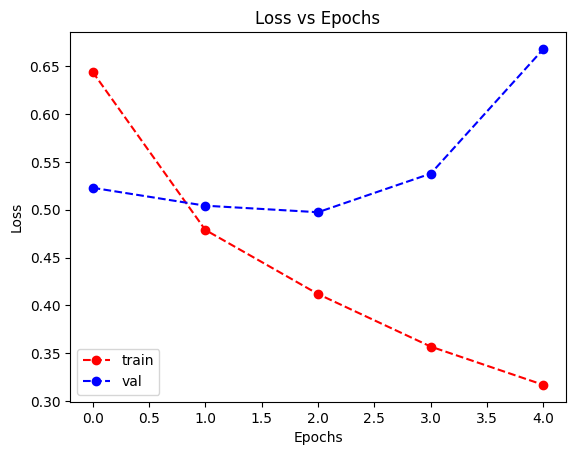

In [ ]:
# plot the training loss and validation loss
plt.figure()
plt.plot(history.history['loss'],c="r",label="train",linestyle='--', marker='o')
plt.plot(history.history['val_loss'],c="b",label="val",linestyle='--', marker='o')
plt.title("Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

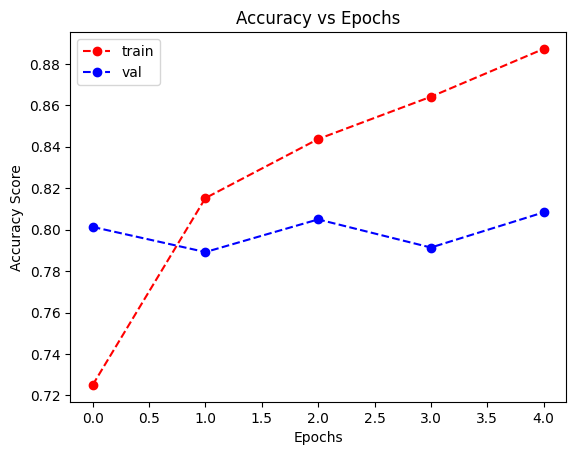

In [ ]:
# plot the training Accuracy and validation Accuracy
plt.figure()
plt.plot(history.history['accuracy'],c="r",label="train",linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'],c="b",label="val",linestyle='--', marker='o')
plt.title("Accuracy vs Epochs")
plt.ylabel("Accuracy Score")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
# # Save the model

# model_path = 'saved_models/RNN.h5'
# model.save(model_path)
# print(f'Model saved to {model_path}')